In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import PowerTransformer


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [2]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [3]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [4]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6,  edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [6]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# SELEÇÃO DE MODELO


## Carregamento e visualização inicial da série

In [7]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_9 = df.iloc[:,8]
serie_9.head()

,#9
0,0.050549
1,0.019767
2,0.049544
3,0.087832
4,0.075998


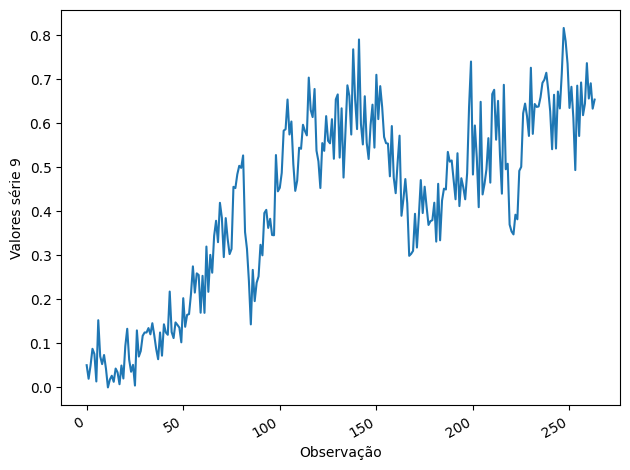

In [8]:
fig, ax = plt.subplots()

ax.plot(serie_9)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 9')

fig.autofmt_xdate()
plt.tight_layout()


## Busca por sinais de sazonalidade

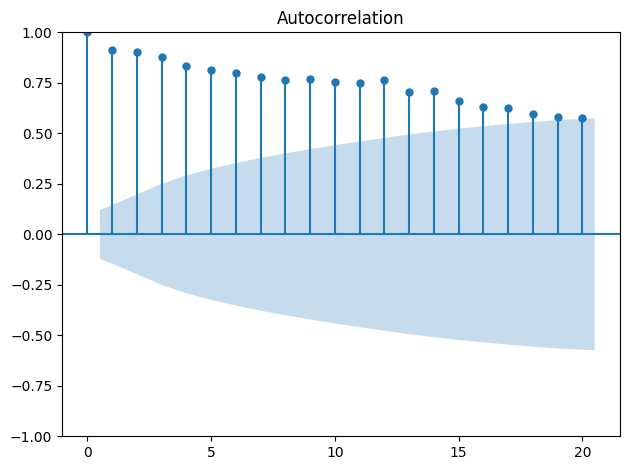

In [9]:
plot_acf(serie_9, lags=20);
plt.tight_layout()

In [10]:
advanced_decomposition = STL(serie_9,period=12).fit()

## Conjunto de treino

In [11]:
test = pd.DataFrame()
test["Values"] = serie_9.iloc[-12:]
test['naive_seasonal'] = serie_9.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_9.iloc[-24:-12].mean()

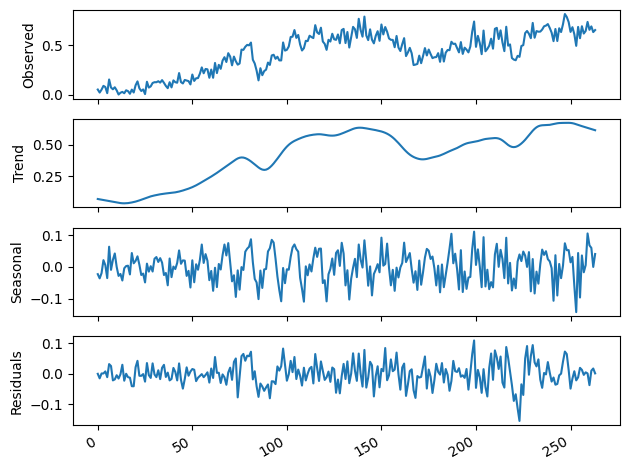

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA

In [13]:
check_stationarity(serie_9,seasonal_period=12)

{'adf_stat': np.float64(-3.155130346614261),
 'p_value': np.float64(0.02273330300693576),
 'stationary': True,
 'diffs_needed': 0,
 'seasonal_diffs_needed': 1}

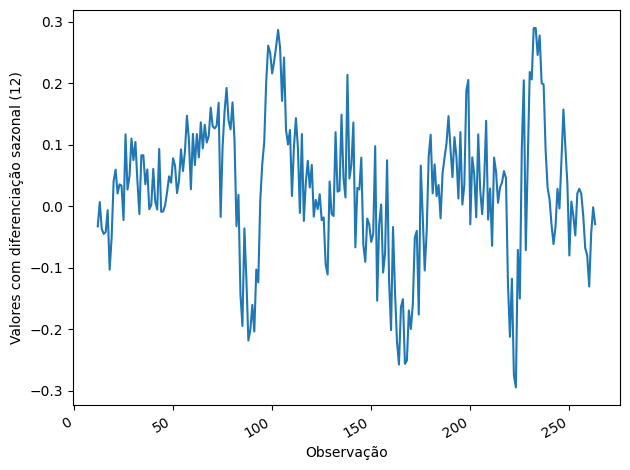

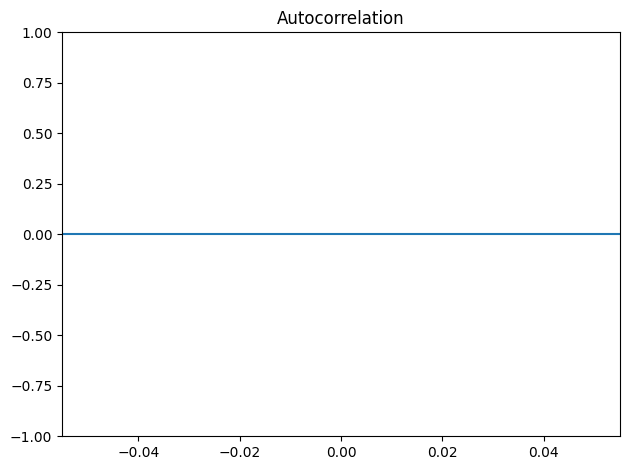

In [14]:
seasonal_diff = serie_9.diff(12)
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento

In [15]:
train = serie_9[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)


```
 from itertools import product

 ps = range(0, 5)
 qs = range(0, 5)
 Ps = range(0, 5)
 Qs = range(0, 5)

 SARIMA_order_list = list(product(ps, qs, Ps, Qs))

 train = serie_1[:-12]

 d = 1
 D = 0
 s = 12

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(9,1,16) | AIC = -458.804229 \\
* SARIMA(4,0,3)(4,1,3,12) | AIC = -429.267563


In [16]:
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(4,1,11), seasonal_order=(0,0,0,12), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)


SARIMA_model = SARIMAX(train_transformed, order=(4,0,3), seasonal_order=(4,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

In [17]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


In [18]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred
252,0.612374,0.627855,0.671323,0.676113,0.674171
253,0.494056,0.541434,0.671323,0.617691,0.577153
254,0.685953,0.665218,0.671323,0.666244,0.658233
255,0.571503,0.543091,0.671323,0.586884,0.585020
256,0.693187,0.672564,0.671323,0.653877,0.617163
257,0.618826,0.634170,0.671323,0.681191,0.627541
258,0.645230,0.713183,0.671323,0.684069,0.701242
259,0.737122,0.817045,0.671323,0.689793,0.746298
260,0.656749,0.787096,0.671323,0.673315,0.689020
261,0.691321,0.735553,0.671323,0.689171,0.695494


### Análise de resíduos

In [19]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.935419
  2     0.915766
  3     0.975324
  4     0.747153
  5     0.757258
  6     0.852442
  7     0.898608
  8     0.935433
  9     0.948361
  10    0.591943
  11    0.479223
  12    0.049369
  13    0.071531
  14    0.057770
  15    0.036590
  16    0.010890
  17    0.014805
  18    0.017641
  19    0.016305
  20    0.019891
  21    0.021308
  22    0.029508
  23    0.038914
  24    0.045012
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(11)},
 'squared_residuals': {'p_values': 1     2.315255e-03
  2     6.217691e-03
  3     9.561059e-03
  4     6.791737e-04
  5     3.822142e-05
  6     1.209087e-07
  7     3.324829e-07
  8     8.205523e-07
  9     1.739514e-06
  10    2.585623e-07
  11    4.126290e-07
  12    4.507363e-07
  13    8.876799e-07
  14    8.969389e-07
  15    1.344986e-06
  16    2.761997e-07
  17    2.439546e-07
  18    4.856745e-07
  19    9.447252e-07
  20    1.270301e-08
  21    1.989037e-08
  22    1.077879e-08
  23 

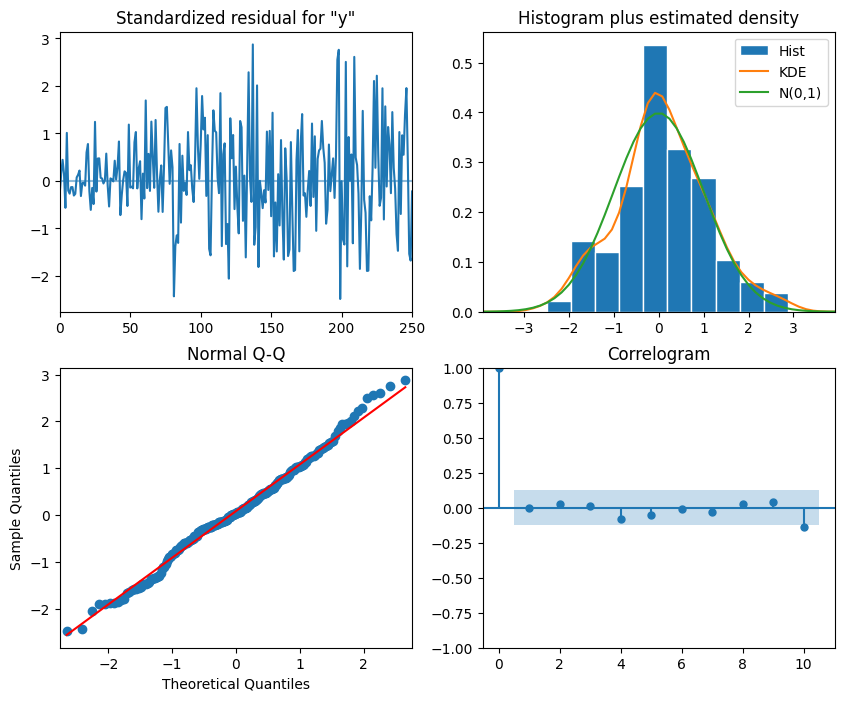

In [20]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [21]:
check_white_noise(SARIMA_model_fit.resid, lags = 12)

{'residuals': {'p_values': 1     0.446254
  2     0.281923
  3     0.333287
  4     0.352493
  5     0.473495
  6     0.572314
  7     0.635386
  8     0.164143
  9     0.229549
  10    0.275087
  11    0.352377
  12    0.392292
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(0)},
 'squared_residuals': {'p_values': 1     0.000146
  2     0.000735
  3     0.000861
  4     0.001168
  5     0.001531
  6     0.001618
  7     0.000545
  8     0.001114
  9     0.000563
  10    0.000882
  11    0.001542
  12    0.002161
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(12)}}

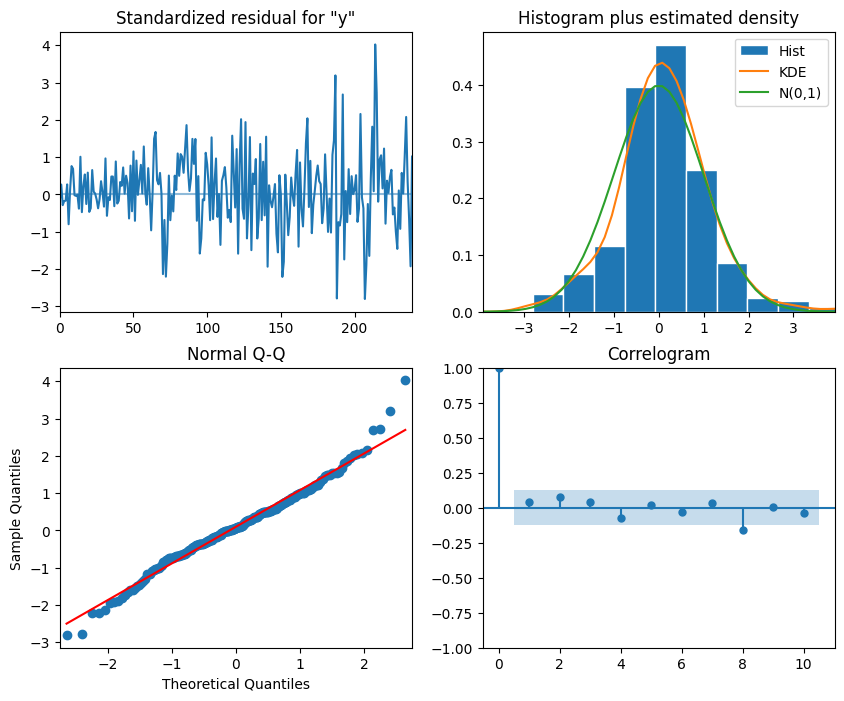

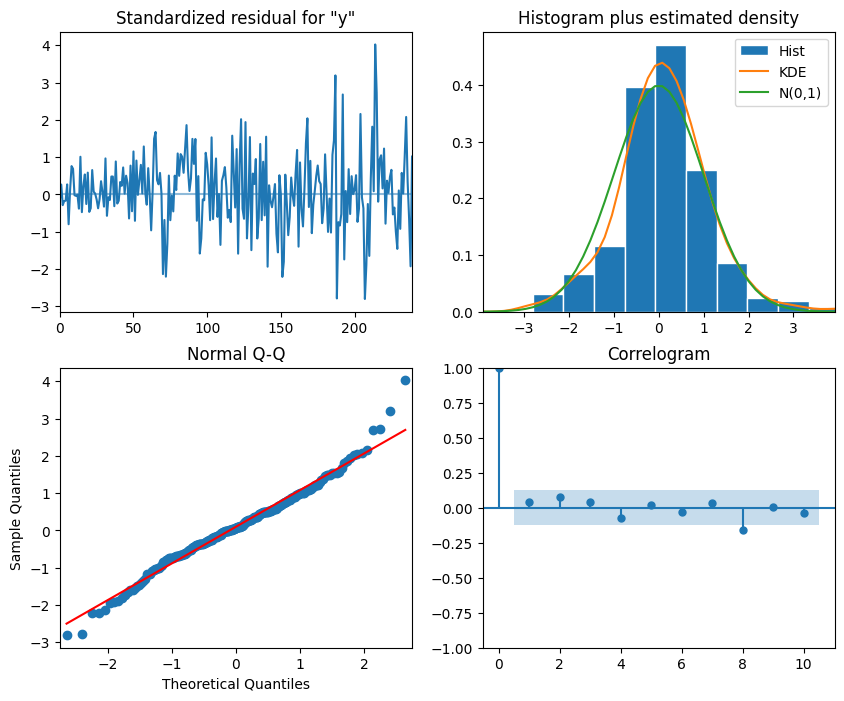

In [22]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

## Holt-Winters

### Treinamento

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_9[:-12]
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)
ES = ExponentialSmoothing(train_transformed,trend='add', damped_trend=True)
ES_fit = ES.fit()
forecast_1 =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

ES3 = ExponentialSmoothing(train, trend='add')
ES3_fit = ES3.fit()

test["HW"] = forecast_1
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.612374,0.627855,0.671323,0.676113,0.674171,0.692211,0.693652
253,0.494056,0.541434,0.671323,0.617691,0.577153,0.693151,0.696226
254,0.685953,0.665218,0.671323,0.666244,0.658233,0.694087,0.698799
255,0.571503,0.543091,0.671323,0.586884,0.585020,0.695017,0.701373
256,0.693187,0.672564,0.671323,0.653877,0.617163,0.695942,0.703946
257,0.618826,0.634170,0.671323,0.681191,0.627541,0.696862,0.706519
258,0.645230,0.713183,0.671323,0.684069,0.701242,0.697776,0.709093
259,0.737122,0.817045,0.671323,0.689793,0.746298,0.698686,0.711666
260,0.656749,0.787096,0.671323,0.673315,0.689020,0.699590,0.714240
261,0.691321,0.735553,0.671323,0.689171,0.695494,0.700489,0.716813


In [24]:
print("Residuos 1:" + str(check_white_noise(ES_fit.resid)))

Residuos 1:{'residuals': {'p_values': 1     5.641523e-01
2     4.003102e-01
3     6.357007e-02
4     1.604002e-03
5     3.989078e-04
6     9.319955e-04
7     3.665628e-05
8     5.027683e-06
9     6.299550e-06
10    1.255225e-05
11    2.672612e-05
12    1.724087e-12
13    3.506074e-13
14    2.302988e-15
15    1.807921e-15
16    7.047095e-17
17    1.531631e-16
18    9.524506e-17
19    4.458045e-17
20    8.958581e-17
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(17)}, 'squared_residuals': {'p_values': 1     7.908562e-07
2     1.396193e-06
3     9.095077e-07
4     4.637014e-08
5     7.763714e-11
6     1.686299e-13
7     1.045798e-13
8     3.485957e-13
9     6.879193e-13
10    1.959768e-13
11    4.707602e-15
12    5.762012e-16
13    9.324622e-16
14    1.118394e-15
15    2.158851e-15
16    2.091360e-17
17    2.794610e-20
18    8.013762e-20
19    2.237224e-19
20    2.025398e-19
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(20)}}


In [25]:
ES_fit.summary()

Dep. Variable:,None,No. Observations:,252
Model:,ExponentialSmoothing,SSE,3.270
Optimized:,True,AIC,-1084.852
Trend:,Additive,BIC,-1067.205
Seasonal:,None,AICC,-1084.393
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:57:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4785461,alpha,True
smoothing_trend,0.000000,beta,True


## Theta

In [26]:
from statsmodels.tsa.forecasting.theta import ThetaModel

pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

# Fit the Theta model
theta_model = ThetaModel(train_transformed,period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
test["Theta"] = pt.inverse_transform(theta_forecast.values.reshape(-1, 1)).flatten()
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                  endog   No. Observations:                  252
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        17:57:48   Period:                             12
Sample:                             0                                         
                                  252                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    0.003182808540021899
alpha   0.4710088463783009
--------------------------
Forecast: 252    0.968923
253    0.856631
254    0.973036
255    0.901751
256    0.965286
257    0.947317
258    1.041255
259    1.050993
260    1.016225
261    1.064235
262    1.016052
263    0.930214
Name: forecast, dtype: float64


## Visualização das predições


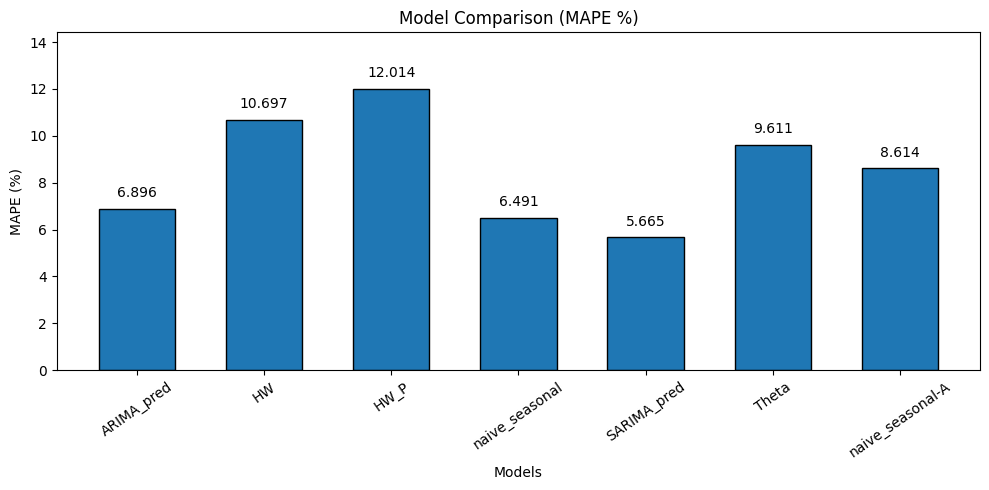

{'ARIMA_pred': np.float64(6.896251510646835),
 'HW': np.float64(10.697204128335),
 'HW_P': np.float64(12.014449534635823),
 'naive_seasonal': np.float64(6.4905176772305815),
 'SARIMA_pred': np.float64(5.665461462387245),
 'Theta': np.float64(9.611402968436),
 'naive_seasonal-A': np.float64(8.61405665567835)}

In [27]:
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','SARIMA_pred','Theta','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

In [28]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta
252,0.612374,0.627855,0.671323,0.676113,0.674171,0.692211,0.693652,0.693906
253,0.494056,0.541434,0.671323,0.617691,0.577153,0.693151,0.696226,0.630214
254,0.685953,0.665218,0.671323,0.666244,0.658233,0.694087,0.698799,0.696189
255,0.571503,0.543091,0.671323,0.586884,0.585020,0.695017,0.701373,0.656134
256,0.693187,0.672564,0.671323,0.653877,0.617163,0.695942,0.703946,0.691885
257,0.618826,0.634170,0.671323,0.681191,0.627541,0.696862,0.706519,0.681861
258,0.645230,0.713183,0.671323,0.684069,0.701242,0.697776,0.709093,0.733556
259,0.737122,0.817045,0.671323,0.689793,0.746298,0.698686,0.711666,0.738817
260,0.656749,0.787096,0.671323,0.673315,0.689020,0.699590,0.714240,0.719951
261,0.691321,0.735553,0.671323,0.689171,0.695494,0.700489,0.716813,0.745943


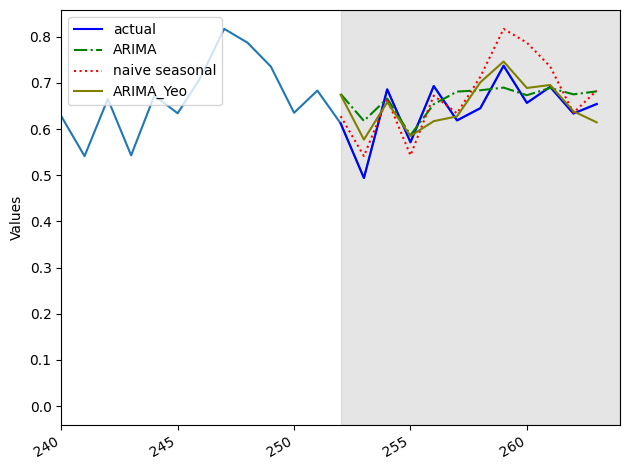

In [29]:
fig, ax = plt.subplots()

ax.plot(serie_9)
ax.plot(test["Values"], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA')
#ax.plot(test['HW'], 'cyan', label='ES')
#ax.plot(test['Theta'], 'black', label='Theta')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['SARIMA_pred'], 'olive', label='ARIMA_Yeo')
#ax.plot(test['HW_P'], 'tan', label='ES-Y')
#ax.plot(test['naive_seasonal-A'] , 'lavender', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(240, 264)

fig.autofmt_xdate()
plt.tight_layout()

## Métricas finais

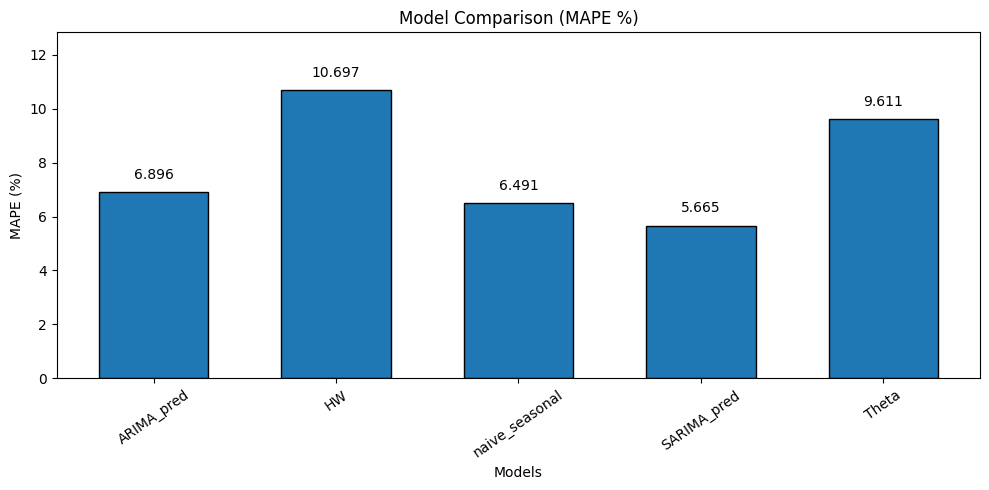

{'ARIMA_pred': np.float64(6.896251510646835),
 'HW': np.float64(10.697204128335),
 'naive_seasonal': np.float64(6.4905176772305815),
 'SARIMA_pred': np.float64(5.665461462387245),
 'Theta': np.float64(9.611402968436)}

In [30]:
columns = ['ARIMA_pred','HW','naive_seasonal','SARIMA_pred','Theta']
plot_model_mape(test,'Values',columns)

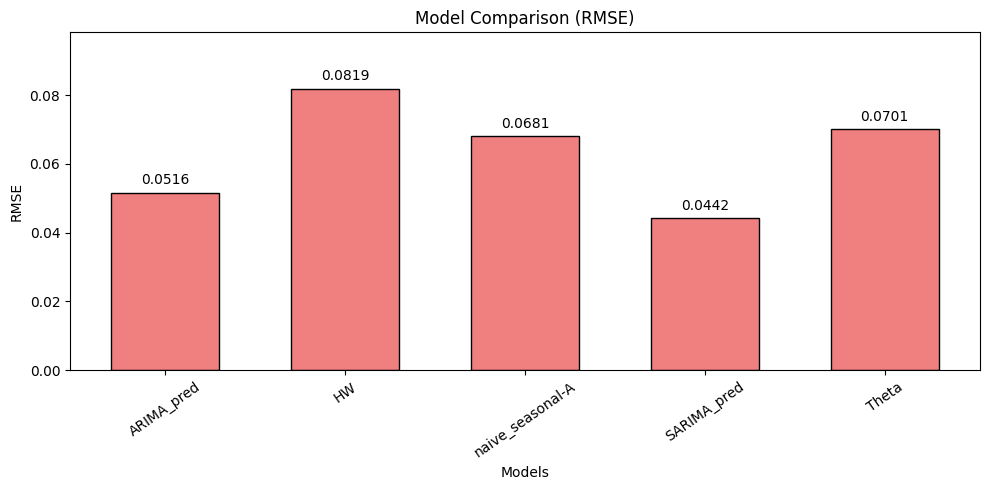

In [31]:
columns_to_plot = ['ARIMA_pred','HW','naive_seasonal-A','SARIMA_pred','Theta']
rmse_results = plot_model_rmse(test, 'Values', columns_to_plot)

# Previsão para a série (próximos 12 meses)

In [32]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(serie_9.values.reshape(-1, 1)).flatten(), index=serie_9.index)


SARIMA_model = SARIMAX(train_transformed, order=(4,0,3), seasonal_order=(4,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

forecast_steps = 12
forecast_SARIMA = SARIMA_model_fit.forecast(steps=forecast_steps)

forecast_original_scale = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()

forecast_original_scale


array([0.63965018, 0.56628568, 0.67255665, 0.61875094, 0.69268485,
       0.64420076, 0.704296  , 0.74065536, 0.66052463, 0.71193586,
       0.65922224, 0.60841596])

In [33]:

horizon = len(forecast_original_scale)

with open("9.csv", "w") as f:
    for i, value in enumerate(forecast_original_scale, 1):
        f.write(f"{value:};\n")
